### 변수명 정리
(원 변수명, 새로운 변수명, 변수 설명 순으로 정리)

pid : pid (pid)       
a177102 : wstart_h (업무 시작 시)       
a177103 : wstart_m (업무 시작 분)      
a177104 : wend_d (업무 종료 일)      
p174301 : jobsat (직무만족도)      
p171003 : fixedwt (정규근로시간여부)      
p171004 : wtime (주당 평균 근로시간)      
p174321 : wspacesat (전반적일자리만족도)      
p174322 : wsat (전반적일만족도)      
p175501 : marri (혼인상태)      
p179071 : childbirth (자녀 출산경험 유무)      
p170314 : jobty (종사상지위)      
p170101: gend (성별)      
p171621: wbonus (성과급제여부)      
p170104: birth (생년)      
p170401: comp_type (기업형태)      

In [5]:
install.packages("foreign")
install.packages("dplyr")
library(foreign)
library(dplyr)

Warning message:
"unable to access index for repository http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/3.5:
  URL 'http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/3.5/PACKAGES'를 열 수 없습니다"Warning message:
"package 'foreign' is in use and will not be installed"Warning message:
"unable to access index for repository http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/3.5:
  URL 'http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/3.5/PACKAGES'를 열 수 없습니다"Warning message:
"package 'dplyr' is in use and will not be installed"

read.spss 명령어 활용해 자료 불러오기( 부가조사, 개인별)

In [6]:
dt17_a <- read.spss("C:/Users/eunee/khu_sda_project/data/klips17a.sav",
                   use.value.labels = FALSE, to.data.frame = TRUE)
dt17_p <- read.spss("C:/Users/eunee/khu_sda_project/data/klips17p_i.sav",
                   use.value.labels = FALSE, to.data.frame = TRUE)

### 부가조사 : ```rdt_a```

In [7]:
rdt_a <- subset(dt17_a,
             select = c(pid, a177102, a177103, a177104))
names(rdt_a) <- c("pid", "wstart_h", "wstart_m", "wend_d")
str(rdt_a)

'data.frame':	11686 obs. of  4 variables:
 $ pid     : num  101 401 402 902 501401 ...
 $ wstart_h: num  7 9 13 9 9 NA 4 10 9 NA ...
 $ wstart_m: num  0 0 0 0 0 NA 0 30 0 NA ...
 $ wend_d  : num  1 1 1 1 1 NA 1 1 1 NA ...


### 개인별 : ```rdt_p```

In [8]:
rdt_p <- subset(dt17_p,
               select = c(pid, p174301, p171003, p171004, p174321, p174322, p175501, p179071, p170314, p170101, p171621, p170104, p170401))
names(rdt_p) <- c("pid", "jobsat", "fixedwt", "wtime", "wspacesat", "wsat", "marri", "childbirth", "jobty", "gend", "wbonus", "birth", "com_type")
str(rdt_p)

'data.frame':	13168 obs. of  13 variables:
 $ pid       : num  101 102 201 202 203 401 402 602 902 903 ...
 $ jobsat    : num  4 3 3 3 NA 4 4 3 4 NA ...
 $ fixedwt   : num  2 1 1 1 NA 1 NA 1 1 NA ...
 $ wtime     : num  24 NA NA NA NA NA NA NA NA NA ...
 $ wspacesat : num  3 3 3 3 NA 2 2 3 2 NA ...
 $ wsat      : num  3 3 3 3 NA 2 2 3 2 NA ...
 $ marri     : num  5 5 4 4 2 2 2 5 2 2 ...
 $ childbirth: num  NA NA NA NA NA NA NA NA NA NA ...
 $ jobty     : num  3 3 3 2 NA 1 4 2 1 NA ...
 $ gend      : num  2 1 1 2 2 1 2 2 2 2 ...
 $ wbonus    : num  2 2 2 2 NA 2 NA 2 2 NA ...
 $ birth     : num  1941 1968 1951 1954 1979 ...
 $ com_type  : num  6 1 1 1 NA 3 NA 3 4 NA ...


### ```rdt_i``` : ```rdt_a```, ```rdt_p``` 에 대한 merge(inner join)

In [9]:
rdt_i <- merge(rdt_a, rdt_p, by = "pid")
str(rdt_i)

'data.frame':	11679 obs. of  16 variables:
 $ pid       : num  101 102 203 401 402 ...
 $ wstart_h  : num  7 8 NA 9 13 9 NA NA 4 10 ...
 $ wstart_m  : num  0 30 NA 0 0 0 NA NA 0 30 ...
 $ wend_d    : num  1 1 NA 1 1 1 NA NA 1 1 ...
 $ jobsat    : num  4 3 NA 4 4 4 NA NA 2 3 ...
 $ fixedwt   : num  2 1 NA 1 NA 1 NA NA 1 1 ...
 $ wtime     : num  24 NA NA NA NA NA NA NA NA NA ...
 $ wspacesat : num  3 3 NA 2 2 2 NA NA 3 3 ...
 $ wsat      : num  3 3 NA 2 2 2 NA NA 3 3 ...
 $ marri     : num  5 5 2 2 2 2 2 4 2 2 ...
 $ childbirth: num  NA NA NA NA NA NA NA NA NA NA ...
 $ jobty     : num  3 3 NA 1 4 1 NA NA 1 1 ...
 $ gend      : num  2 1 2 1 2 2 2 2 1 2 ...
 $ wbonus    : num  2 2 NA 2 NA 2 NA NA 2 2 ...
 $ birth     : num  1941 1968 1979 1970 1969 ...
 $ com_type  : num  6 1 NA 3 NA 4 NA NA 1 1 ...


### ```rdt_o``` : ```rdt_a```, ```rdt_p``` 에 대한 merge(outer join)

In [10]:
rdt_o <- merge(rdt_a, rdt_p, by = "pid", all = TRUE)
str(rdt_o)

'data.frame':	13175 obs. of  16 variables:
 $ pid       : num  101 102 201 202 203 401 402 602 902 903 ...
 $ wstart_h  : num  7 8 NA NA NA 9 13 NA 9 NA ...
 $ wstart_m  : num  0 30 NA NA NA 0 0 NA 0 NA ...
 $ wend_d    : num  1 1 NA NA NA 1 1 NA 1 NA ...
 $ jobsat    : num  4 3 3 3 NA 4 4 3 4 NA ...
 $ fixedwt   : num  2 1 1 1 NA 1 NA 1 1 NA ...
 $ wtime     : num  24 NA NA NA NA NA NA NA NA NA ...
 $ wspacesat : num  3 3 3 3 NA 2 2 3 2 NA ...
 $ wsat      : num  3 3 3 3 NA 2 2 3 2 NA ...
 $ marri     : num  5 5 4 4 2 2 2 5 2 2 ...
 $ childbirth: num  NA NA NA NA NA NA NA NA NA NA ...
 $ jobty     : num  3 3 3 2 NA 1 4 2 1 NA ...
 $ gend      : num  2 1 1 2 2 1 2 2 2 2 ...
 $ wbonus    : num  2 2 2 2 NA 2 NA 2 2 NA ...
 $ birth     : num  1941 1968 1951 1954 1979 ...
 $ com_type  : num  6 1 1 1 NA 3 NA 3 4 NA ...


### ```rdt_i```의 ```NA``` 알아보기 
(이하 분석은 ```rdt_i```로 진행)

In [11]:
colSums(is.na(rdt_i))

pid   wstart_h   wstart_m     wend_d     jobsat    fixedwt      wtime 
         0       4349       4349       4349       4349       6505      10960 
 wspacesat       wsat      marri childbirth      jobty       gend     wbonus 
      4349       4349          0      11623       4349          0       6505 
     birth   com_type 
         0       6505

In [12]:
head(rdt_i)

pid,wstart_h,wstart_m,wend_d,jobsat,fixedwt,wtime,wspacesat,wsat,marri,childbirth,jobty,gend,wbonus,birth,com_type
101,7,0,1,4,2,24,3,3,5,NA,3,2,2,1941,6
102,8,30,1,3,1,NA,3,3,5,NA,3,1,2,1968,1
203,NA,NA,NA,NA,NA,NA,NA,NA,2,NA,NA,2,NA,1979,NA
401,9,0,1,4,1,NA,2,2,2,NA,1,1,2,1970,3
402,13,0,1,4,NA,NA,2,2,2,NA,4,2,NA,1969,NA
902,9,0,1,4,1,NA,2,2,2,NA,1,2,2,1970,4


```rdt_i```는 ```pid```를 ```key```로 한 inner join이기 때문에 ```pid```의 ```NA```는 0이다.   
우리의 설명변수인 ```wstart_h```와 ```wstart_m```에 해당하지 않거나(```NA```), 모름/무응답(```-1```)인 사례는 연구관심 밖이므로, 이후 클리닝에서 제거하도록 하자.

### 설명변수 클리닝

In [13]:
nrdt_i <- rdt_i
nrdt_i$nwstart_h <- ifelse(nrdt_i$wstart_h == -1, NA, nrdt_i$wstart_h)
nrdt_i$nwstart_m <- ifelse(nrdt_i$wstart_m == -1, NA, nrdt_i$wstart_m)

```ifelse```문을 활용해 ```nrdt_i```의 ```wstart_h```가 ```-1```(모름/무응답) 인 경우 ```NA```, 그렇지 않으면 원래 ```wstart_h``` 값을 주도록 했다. (```wstart_m```)의 경우도 마찬가지로 수행했다.

In [14]:
nrdt_i <- nrdt_i[complete.cases(nrdt_i[ , c("nwstart_h", "nwstart_m")]), ]
colSums(is.na(nrdt_i))

pid   wstart_h   wstart_m     wend_d     jobsat    fixedwt      wtime 
         0          0          0          0          0       2128       6539 
 wspacesat       wsat      marri childbirth      jobty       gend     wbonus 
         0          0          0       7210          0          0       2128 
     birth   com_type  nwstart_h  nwstart_m 
         0       2128          0          0

```complete.cases```를 활용하여 ```nwstart_h```와 ```nwstart_m```에 ```NA```가 있는 행을 제거했다. (모름/무응답에 해당하는 ```-1```도 우리가 위에서 ```NA```로 만들었으므로, 이것도 제거된다.)

In [15]:
head(nrdt_i)

,pid,wstart_h,wstart_m,wend_d,jobsat,fixedwt,wtime,wspacesat,wsat,marri,childbirth,jobty,gend,wbonus,birth,com_type,nwstart_h,nwstart_m
1,101,7,0,1,4,2,24,3,3,5,NA,3,2,2,1941,6,7,0
2,102,8,30,1,3,1,NA,3,3,5,NA,3,1,2,1968,1,8,30
4,401,9,0,1,4,1,NA,2,2,2,NA,1,1,2,1970,3,9,0
5,402,13,0,1,4,NA,NA,2,2,2,NA,4,2,NA,1969,NA,13,0
6,902,9,0,1,4,1,NA,2,2,2,NA,1,2,2,1970,4,9,0
9,1101,4,0,1,2,1,NA,3,3,2,NA,1,1,2,1957,1,4,0


```wstart_h```와 ```wstart_m```에 ```NA```가 있는 행들이 제거되었다.

In [16]:
sum(nrdt_i$nwstart_h == -1)
sum(nrdt_i$nwstart_m == -1)

[1] 0

[1] 0

```nwstart_h```와 ```nwstart_m```에서 ```NA```와 ```-1``` 모두 제거되었다.

In [17]:
nrdt_i$nwstart_m <- ifelse(nrdt_i$nwstart_m == "0", "00", nrdt_i$nwstart_m)
nrdt_i$nwstart_m <- ifelse(nrdt_i$nwstart_m == "1", "01", nrdt_i$nwstart_m)
nrdt_i$nwstart_m <- ifelse(nrdt_i$nwstart_m == "2", "02", nrdt_i$nwstart_m)
nrdt_i$nwstart_m <- ifelse(nrdt_i$nwstart_m == "3", "03", nrdt_i$nwstart_m)
nrdt_i$nwstart_m <- ifelse(nrdt_i$nwstart_m == "4", "04", nrdt_i$nwstart_m)
nrdt_i$nwstart_m <- ifelse(nrdt_i$nwstart_m == "5", "05", nrdt_i$nwstart_m)
nrdt_i$nwstart_m <- ifelse(nrdt_i$nwstart_m == "6", "06", nrdt_i$nwstart_m)
nrdt_i$nwstart_m <- ifelse(nrdt_i$nwstart_m == "7", "07", nrdt_i$nwstart_m)
nrdt_i$nwstart_m <- ifelse(nrdt_i$nwstart_m == "8", "08", nrdt_i$nwstart_m)
nrdt_i$nwstart_m <- ifelse(nrdt_i$nwstart_m == "9", "09", nrdt_i$nwstart_m)

0분을 00분, 1분을 01분 등으로 만드는 작업을 실행했다.

In [18]:
nrdt_i$nwstart <- paste(nrdt_i$nwstart_h, nrdt_i$nwstart_m, sep = "")

```nwstart_h```와 ```nwstart_m```을 ```nwstart```로 합쳐주자.

http://www.mpm.go.kr/mpm/info/infoService/BizService10/ 을 참고해서, (-Inf, 700), (700, 300), ... (1000, Inf)로 범주화하자.

In [44]:
nrdt_i$nwstart_c <- cut(nrdt_i$nwstart,
                       breaks = c(-Inf, 700, 730, 800, 830, 900, 930, 1000, Inf),
                       right = FALSE, labels = c("A", "B", "C", "D", "E", "F", "G", "H"))

A : 7시 이전    
B : 7시 ~ 7시 30분   
C : 7시 30분 ~ 8시   
D : 8시 ~ 8시 30분    
E : 8시 30분 ~ 9시    
F : 9시 ~ 9시 30분   
G : 9시 30분 ~ 10시  
H : 10시 이후     
    
로 범주화했다.

In [42]:
summary(nrdt_i$nwstart_c)

A    B    C    D    E    F    G    H 
 536  438  214 1157 1090 2210  208 1380

```summary``` 함수로 각 범주별 사례수를 확인 가능하며

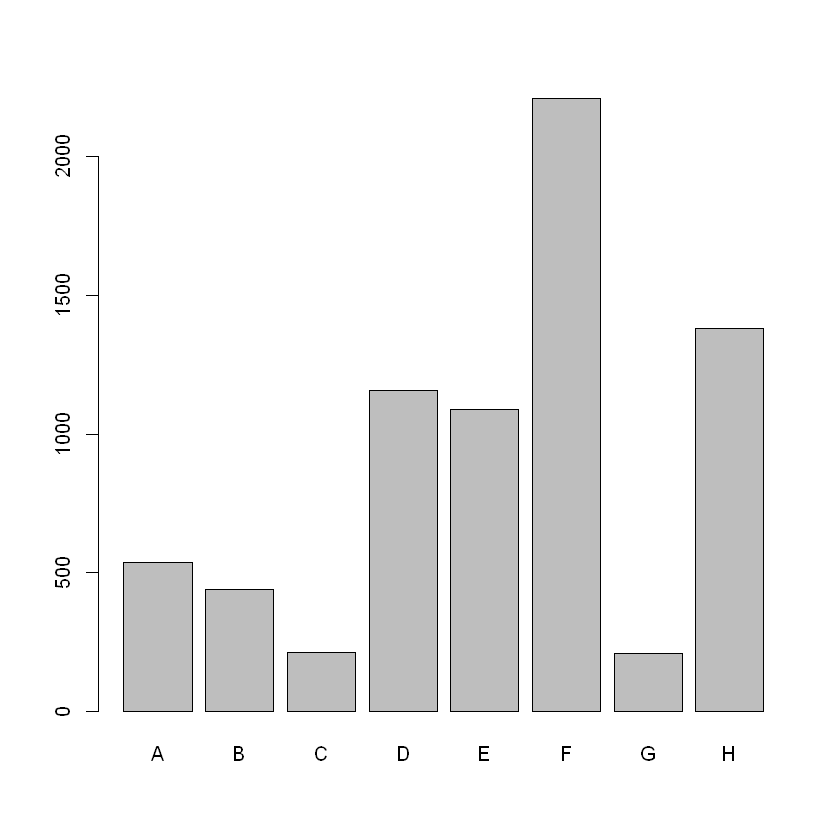

In [43]:
plot(nrdt_i$nwstart_c)

```plot```함수로 막대그래프로 볼 수도 있다.

```nrdt_i$nwstart_c```로 출근 시간을 범주화하였다.